In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("online_shoppers_intention.csv")
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Check for missing values


In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

# Check for unique values


In [4]:
categorical_columns = ['Month', 'VisitorType', 'Weekend', 'Revenue']

for column in categorical_columns:
    print(f"{column}: {data[column].value_counts()}")
    print("")

Month: Month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64

VisitorType: VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64

Weekend: Weekend
False    9462
True     2868
Name: count, dtype: int64

Revenue: Revenue
False    10422
True      1908
Name: count, dtype: int64



# Feature Engineering

## Apply ordinal encoding


In [5]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

categorical_columns = ['Month', 'VisitorType', 'Weekend', 'Revenue']
data_encoded = ordinal_encoder.fit_transform(data[categorical_columns])
X_encoded = pd.DataFrame(data_encoded, columns=categorical_columns)
X_encoded.head()

,Month,VisitorType,Weekend,Revenue
0,2.0,2.0,0.0,0.0
1,2.0,2.0,0.0,0.0
2,2.0,2.0,0.0,0.0
3,2.0,2.0,0.0,0.0
4,2.0,2.0,1.0,0.0


## Apply scaling

In [6]:
from sklearn.preprocessing import RobustScaler

numerical_columns = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
scaler = RobustScaler()

data_scaled = scaler.fit_transform(data[numerical_columns])
X_scaled = pd.DataFrame(data_scaled, columns=numerical_columns)
data_scaled_encoded = pd.concat([X_scaled, X_encoded], axis=1)
data_scaled_encoded.head()

# data_scaled_encoded = pd.concat([data[numerical_columns], X_encoded], axis=1)
# data_scaled_encoded.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,VisitorType,Weekend,Revenue
0,-0.25,-0.080424,0.0,0.0,-0.548387,-0.467912,11.710742,4.895621,0.0,0.0,2.0,2.0,0.0,0.0
1,-0.25,-0.080424,0.0,0.0,-0.516129,-0.417913,-0.185128,2.095621,0.0,0.0,2.0,2.0,0.0,0.0
2,-0.25,-0.080424,0.0,0.0,-0.548387,-0.467912,11.710742,4.895621,0.0,0.0,2.0,2.0,0.0,0.0
3,-0.25,-0.080424,0.0,0.0,-0.516129,-0.465829,2.788840,3.215621,0.0,0.0,2.0,2.0,0.0,0.0
4,-0.25,-0.080424,0.0,0.0,-0.258065,0.022315,1.004459,0.695621,0.0,0.0,2.0,2.0,1.0,0.0


# Feature Selection

## Embedded Methods


### Lasso l1 regularization


**The reason why only L1 is applied:** L1 regularization has shrinks some of the coefficients to zero, therefore indicating that a certain predictor or certain features will be multiplied by zero to estimate the target. Thus, it won’t be added to the final prediction of the target—this means that these features can be removed because they aren’t contributing to the final prediction.

**However on L2 and combined L1/L2:** doesn’t set the coefficient to zero, but only approaching zero—that’s why we use only L1 in feature selection.

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

X = data_scaled_encoded.drop('Revenue', axis=1)
y = data_scaled_encoded['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

Lasso(alpha=0.01)

In [9]:
coeff = lasso.coef_
coeff

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.40727322e-05,
        9.39942645e-03,  9.68531044e-03, -0.00000000e+00, -2.00571653e-02,
        9.20203585e-03, -0.00000000e+00,  7.81741553e-03, -7.47179641e-03,
        0.00000000e+00])

In [10]:
df_coeff = pd.DataFrame({"features":X.columns,"coeff":coeff})
df_coeff.sort_values("coeff")

,features,coeff
7,ExitRates,-0.020057
11,VisitorType,-0.007472
0,Administrative,0.000000
1,Administrative_Duration,0.000000
2,Informational,0.000000
6,BounceRates,-0.000000
9,SpecialDay,-0.000000
12,Weekend,0.000000
3,Informational_Duration,0.000044
10,Month,0.007817


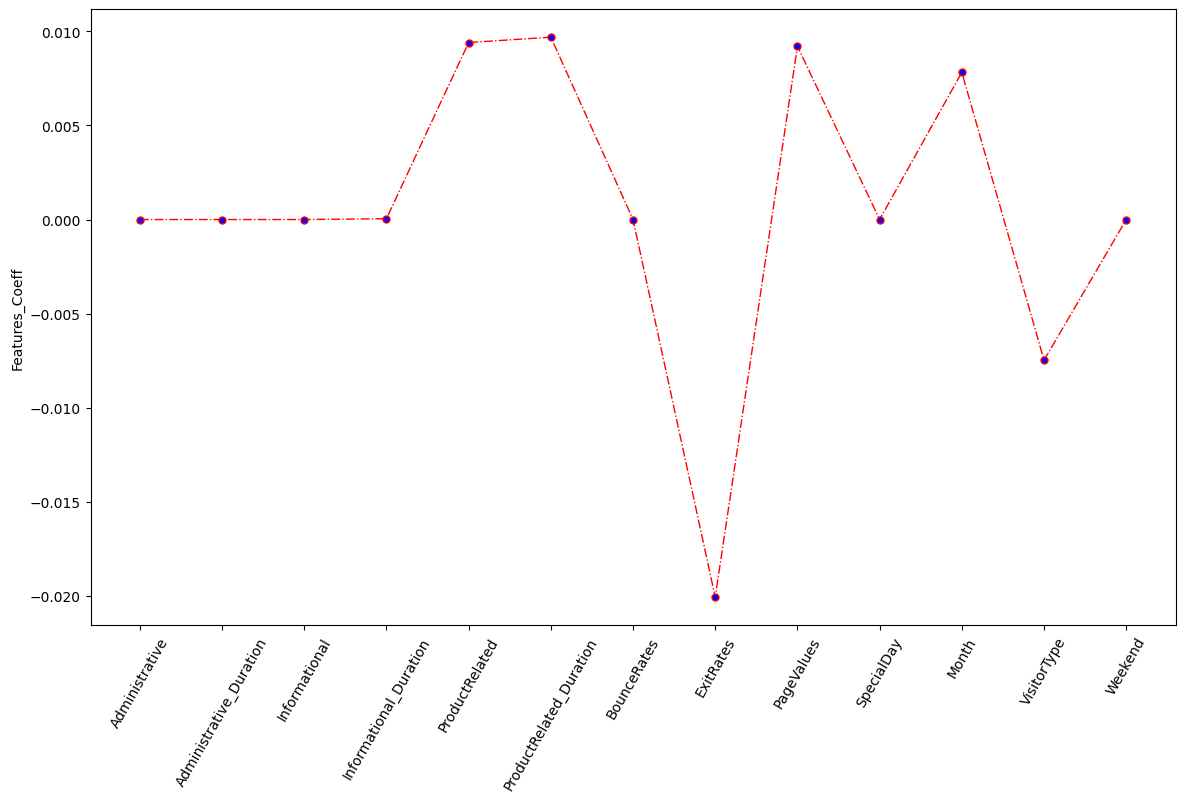

In [11]:
# Lets plot the coeff with features
plt.figure(figsize=(14,8))
plt.plot(range(len(X.columns)),coeff, color='red', linestyle='dashdot', linewidth = 1,marker='o', 
         markerfacecolor='blue', markersize=5)
plt.xticks(range(len(X.columns)),X.columns,rotation=60)
plt.ylabel("Features_Coeff")
plt.show()

<Axes: xlabel='features', ylabel='coeff'>

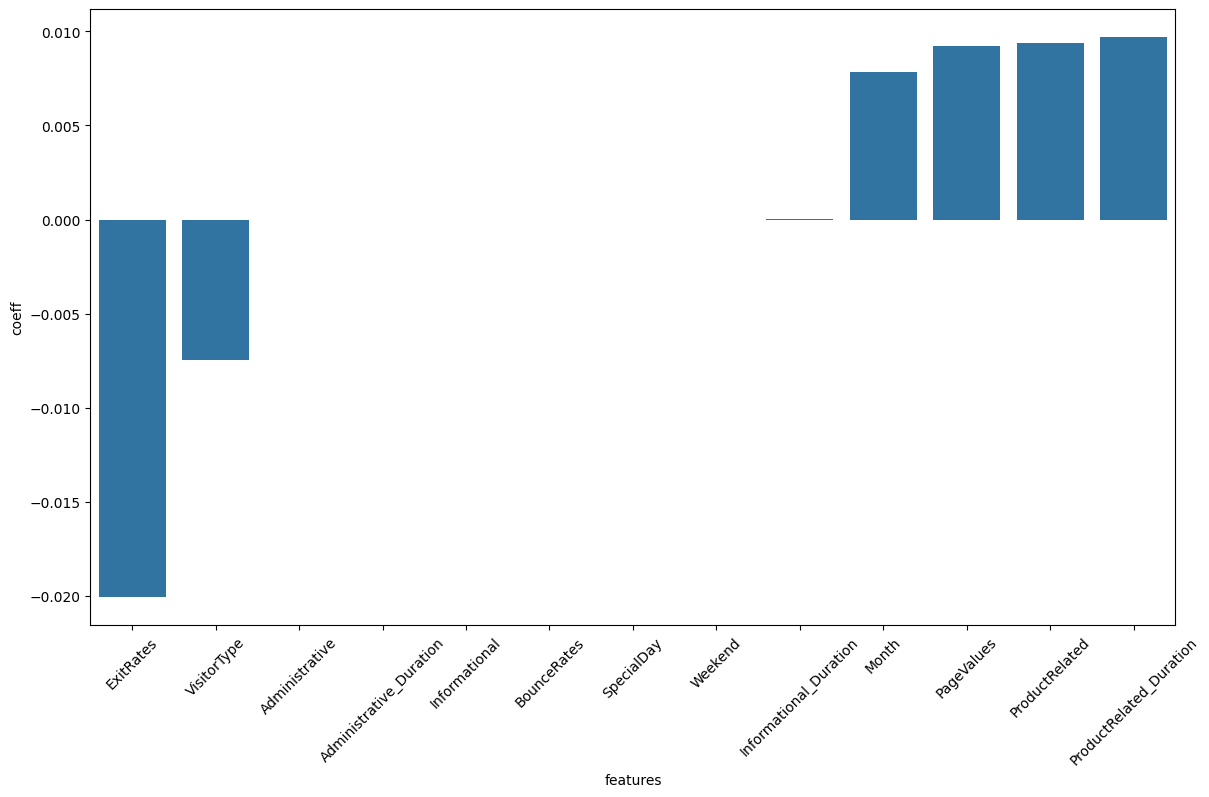

In [12]:
# Use Bar chart to show coeff
plt.figure(figsize=(14,8))
df_coeff.set_index('coeff')
# sort in ascending order to better visualization.
df_coeff = df_coeff.sort_values('coeff')
# plot the feature coeff in bars.
plt.xticks(rotation=45)
sns.barplot(x="features",y= "coeff", data=df_coeff)

In [13]:
selected_features = df_coeff[df_coeff['coeff'] != 0]['features'].tolist()
print(selected_features)

['ExitRates', 'VisitorType', 'Informational_Duration', 'Month', 'PageValues', 'ProductRelated', 'ProductRelated_Duration']


### Tree based Feature Selection


In [14]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
dtc = DecisionTreeClassifier(random_state=42)

rfc.fit(X_train, y_train)
etc.fit(X_train, y_train)
gbc.fit(X_train, y_train)
dtc.fit(X_train, y_train)

accuracy_rfc = accuracy_score(y_test, rfc.predict(X_test))
accuracy_etc = accuracy_score(y_test, etc.predict(X_test))
accuracy_gbc = accuracy_score(y_test, gbc.predict(X_test))
accuracy_dtc = accuracy_score(y_test, dtc.predict(X_test))

selector_rfc = SelectFromModel(rfc, prefit=True)
selector_rfc.fit(X_train, y_train)

selector_etc = SelectFromModel(etc, prefit=True)
selector_etc.fit(X_train, y_train)

selector_gbc = SelectFromModel(gbc, prefit=True)
selector_gbc.fit(X_train, y_train)

selector_dtc = SelectFromModel(dtc, prefit=True)
selector_dtc.fit(X_train, y_train)

selected_features_rfc = X_train.columns[selector_rfc.get_support()].tolist()
selected_features_etc = X_train.columns[selector_etc.get_support()].tolist()
selected_features_gbc = X_train.columns[selector_gbc.get_support()].tolist()
selected_features_dtc = X_train.columns[selector_dtc.get_support()].tolist()

In [15]:
models = ['Random Forest', 'Extra Trees', 'Gradient Boosting', 'Decision Tree']
accuracy_scores = [accuracy_rfc, accuracy_etc, accuracy_gbc, accuracy_dtc]

print("Selected Features:")
for model, features in zip(models, [selected_features_rfc, selected_features_etc, selected_features_gbc, selected_features_dtc]):
    print(f"{model}: {features}")

pd.DataFrame({'Model': models, 'Accuracy': accuracy_scores, 'Selected Features': [selected_features_rfc, selected_features_etc, selected_features_gbc, selected_features_dtc]})

Selected Features:
Random Forest: ['ProductRelated', 'ProductRelated_Duration', 'ExitRates', 'PageValues']
Extra Trees: ['ProductRelated', 'ProductRelated_Duration', 'ExitRates', 'PageValues']
Gradient Boosting: ['PageValues']
Decision Tree: ['ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']


,Model,Accuracy,Selected Features
0,Random Forest,0.891727,"[ProductRelated, ProductRelated_Duration, Exit..."
1,Extra Trees,0.887672,"[ProductRelated, ProductRelated_Duration, Exit..."
2,Gradient Boosting,0.893755,[PageValues]
3,Decision Tree,0.860908,"[ProductRelated_Duration, BounceRates, ExitRat..."


## Modeling

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled_encoded[selected_features_rfc], data_scaled_encoded['Revenue'], test_size=0.2, random_state=42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9864, 4)

(2466, 4)

(9864,)

(2466,)

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

def train_and_plot(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
    print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))

    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', round(auc, 3))

    # ROC Curve
    model_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    try:
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        plt.figure(figsize = (12.8 , 6))
        plt.plot(fpr, tpr, label = 'AUC = {})'.\
             format(model_roc_auc.round(4)))
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc = 'lower right')
        plt.show()
    except:
        print('ROC Curve not available for this model')
    print('-' * 50)
    return model

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.svm import SVC

class_weights = {0: (y_train.value_counts().sum() / y_train.value_counts()[0]), 1: (y_train.value_counts().sum() / y_train.value_counts()[1])}

In [19]:
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression()

In [20]:
adj_threshold = pd.DataFrame()
thresholds = [j/20 for j in range(1, 16)]

for i in thresholds:
    y_pred_new_threshold = (model1.predict_proba(X_test)[:, 1] >= i).astype(int)  # calculating the threshold with respect to class 1

    precision_adj_threshold = round(precision_score(y_test, y_pred_new_threshold, average='binary'), 4)
    recall_adj_threshold = round(recall_score(y_test, y_pred_new_threshold, average='binary'), 4)
    F1_score_adj_threshold = round((f1_score(y_test, y_pred_new_threshold, average='binary')), 4)
    metrics_adj_threshold = [precision_adj_threshold, recall_adj_threshold, F1_score_adj_threshold]
    
    name = 'Threshold: ' + str(i)
    adj_threshold[name] = metrics_adj_threshold

adj_threshold.index = ['Precision', 'Recall', 'F1_score']
adj_threshold = adj_threshold.reset_index()

cols = ['Metrics'] + list(adj_threshold.columns[1:])
adj_threshold.columns = cols

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:, 0]
adj_threshold1

Metrics,Precision,Recall,F1_score
Threshold: 0.05,0.2147,0.9805,0.3523
Threshold: 0.1,0.3421,0.8832,0.4932
Threshold: 0.15,0.584,0.7445,0.6545
Threshold: 0.2,0.6383,0.6399,0.6391
Threshold: 0.25,0.6784,0.5645,0.6162
Threshold: 0.3,0.6946,0.5036,0.5839
Threshold: 0.35,0.7181,0.4526,0.5552
Threshold: 0.4,0.7124,0.3917,0.5055
Threshold: 0.45,0.7264,0.3552,0.4771
Threshold: 0.5,0.7326,0.3333,0.4582


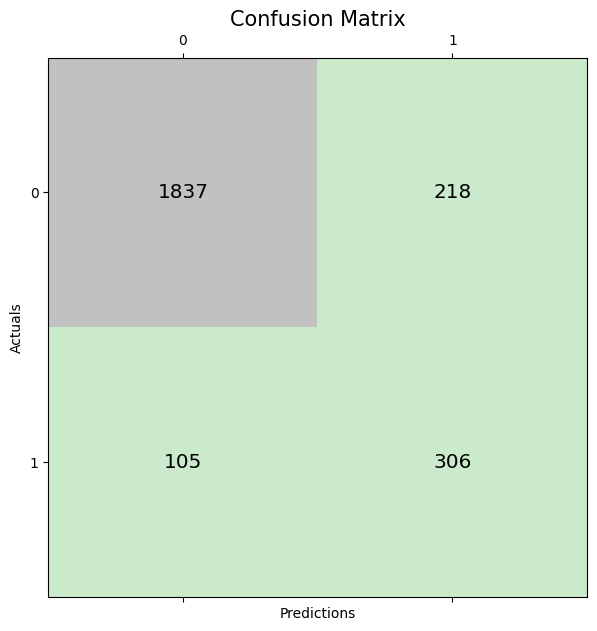

In [21]:
y_pred_new_threshold = (model1.predict_proba(X_test)[:,1]>=0.15).astype(int)


conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_new_threshold)

fig, ax = plt.subplots(figsize=(7, 7))
ax.matshow(conf_matrix, cmap=plt.cm.Accent, alpha=0.4)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
 
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [22]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train[selected_features_rfc], y_train)

  0%|          | 0/6 [00:00<?, ?it/s]

Random Forest
Model accuracy for train set: 0.999
Model accuracy for test set: 0.857

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91      2055
         1.0       0.56      0.71      0.62       411

    accuracy                           0.86      2466
   macro avg       0.75      0.80      0.77      2466
weighted avg       0.88      0.86      0.86      2466


Confusion Matrix:
 [[1821  234]
 [ 118  293]]

Accuracy Score:  0.857


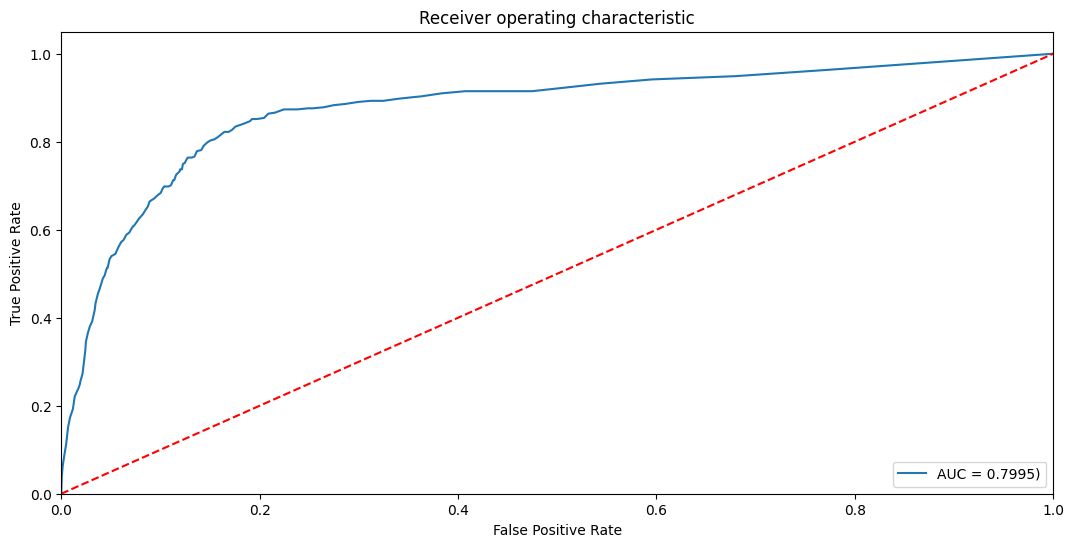

 17%|█▋        | 1/6 [00:04<00:22,  4.42s/it]

--------------------------------------------------
--------------------------------------------------
Logistic Regression
Model accuracy for train set: 0.604
Model accuracy for test set: 0.369

              precision    recall  f1-score   support

         0.0       0.99      0.25      0.39      2055
         1.0       0.21      0.99      0.34       411

    accuracy                           0.37      2466
   macro avg       0.60      0.62      0.37      2466
weighted avg       0.86      0.37      0.38      2466


Confusion Matrix:
 [[ 504 1551]
 [   6  405]]

Accuracy Score:  0.369


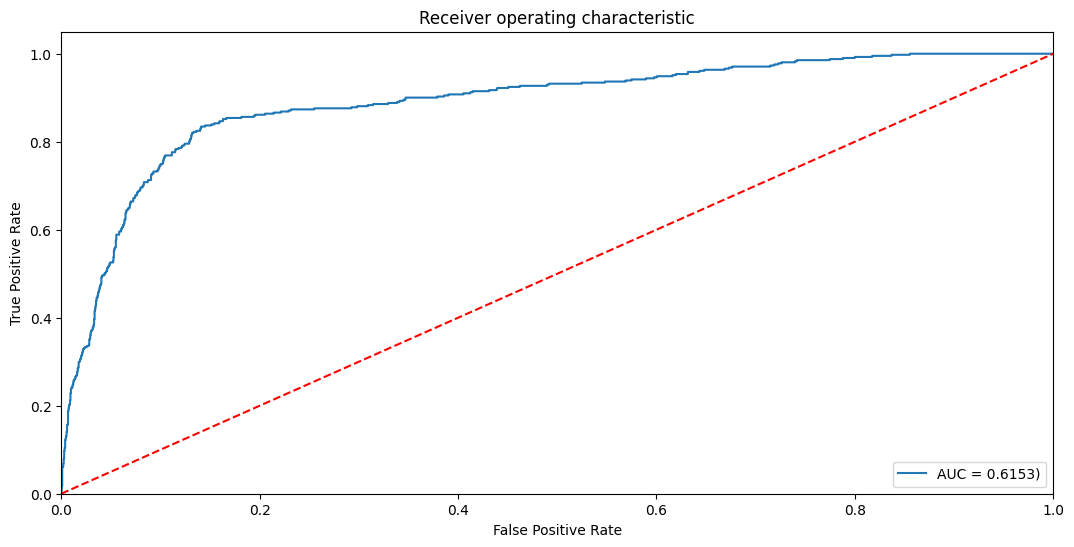

 33%|███▎      | 2/6 [00:04<00:07,  1.92s/it]

--------------------------------------------------
--------------------------------------------------
Gradient Boosting
Model accuracy for train set: 0.868
Model accuracy for test set: 0.869

              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92      2055
         1.0       0.58      0.81      0.67       411

    accuracy                           0.87      2466
   macro avg       0.77      0.84      0.80      2466
weighted avg       0.89      0.87      0.88      2466


Confusion Matrix:
 [[1812  243]
 [  80  331]]

Accuracy Score:  0.869


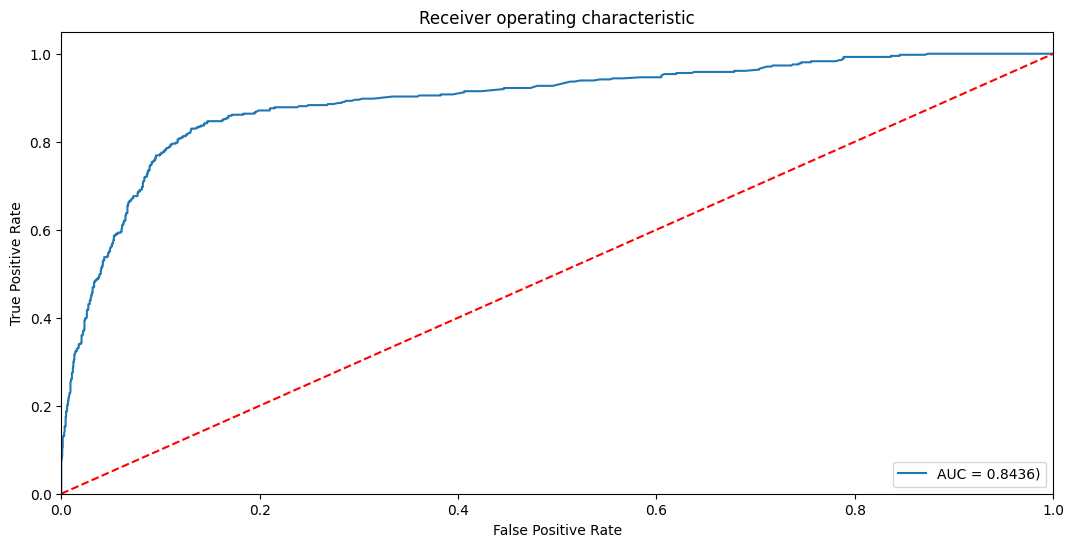

 50%|█████     | 3/6 [00:06<00:06,  2.03s/it]

--------------------------------------------------
--------------------------------------------------
Decision Tree
Model accuracy for train set: 0.999
Model accuracy for test set: 0.830

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89      2055
         1.0       0.49      0.63      0.55       411

    accuracy                           0.83      2466
   macro avg       0.71      0.75      0.72      2466
weighted avg       0.85      0.83      0.84      2466


Confusion Matrix:
 [[1789  266]
 [ 154  257]]

Accuracy Score:  0.83


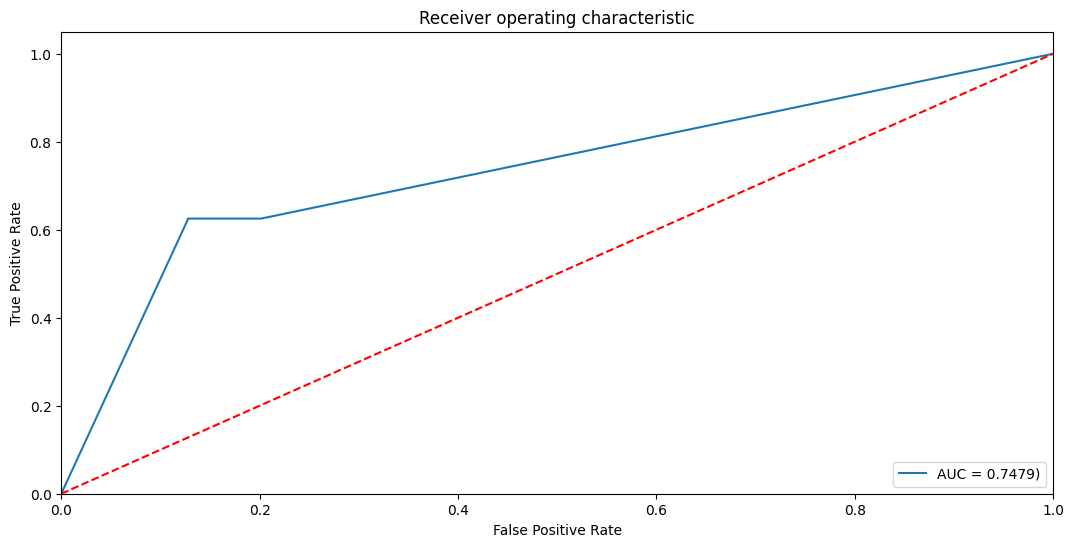

 67%|██████▋   | 4/6 [00:06<00:02,  1.31s/it]

--------------------------------------------------
--------------------------------------------------
Extra Trees
Model accuracy for train set: 0.999
Model accuracy for test set: 0.859

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91      2055
         1.0       0.56      0.71      0.63       411

    accuracy                           0.86      2466
   macro avg       0.75      0.80      0.77      2466
weighted avg       0.88      0.86      0.87      2466


Confusion Matrix:
 [[1828  227]
 [ 120  291]]

Accuracy Score:  0.859


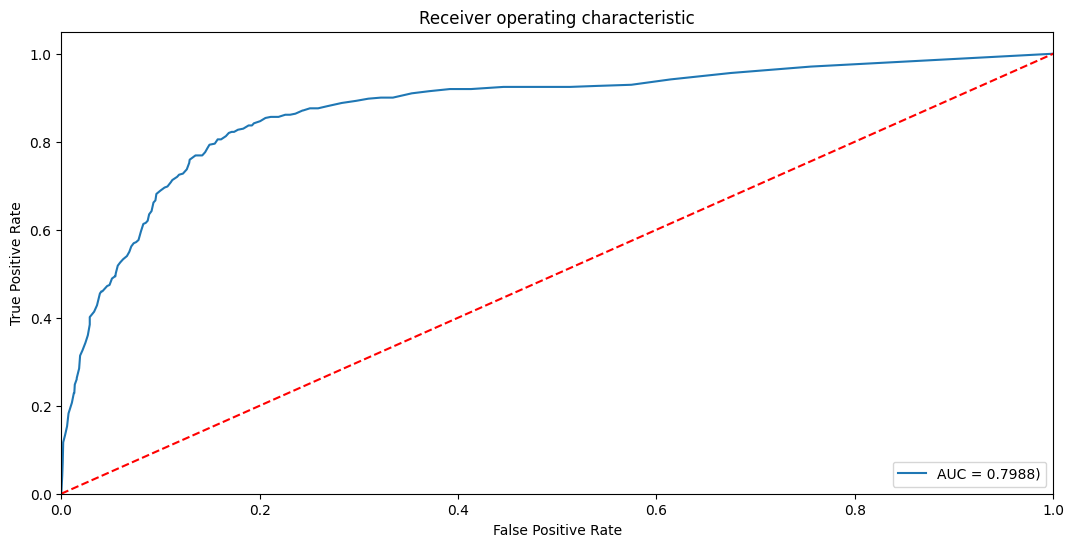

 83%|████████▎ | 5/6 [00:08<00:01,  1.42s/it]

--------------------------------------------------
--------------------------------------------------
SVM
Model accuracy for train set: 0.839
Model accuracy for test set: 0.876

              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92      2055
         1.0       0.60      0.77      0.67       411

    accuracy                           0.88      2466
   macro avg       0.78      0.83      0.80      2466
weighted avg       0.89      0.88      0.88      2466


Confusion Matrix:
 [[1845  210]
 [  95  316]]

Accuracy Score:  0.876


100%|██████████| 6/6 [00:19<00:00,  3.18s/it]

ROC Curve not available for this model
--------------------------------------------------
--------------------------------------------------


In [23]:
from tqdm import tqdm
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(class_weight=class_weights),
    'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(class_weight=class_weights),
    'Extra Trees': ExtraTreesClassifier(class_weight=class_weights),
    'Random Forest': RandomForestClassifier(class_weight=class_weights),
    # 'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(),
    # 'XGBoost': XGBClassifier(
    #             objective='binary:logistic',  # Binary classification
    #             eval_metric='logloss',        # Logarithmic loss for evaluation
    #             use_label_encoder=False,      # Avoid deprecation warnings
    #             random_state=42
    #         ),
    # 'LightGBM': LGBMClassifier(),
    # 'CatBoost': CatBoostClassifier()
}

# Train and evaluate models
for name, model in tqdm(models.items()):
    print(name)
    train_and_plot(model, X_train_smote, y_train_smote, X_test[selected_features_rfc], y_test)
    print('-' * 50)


## Hyperparameter tuning

### Calculate class weights


In [24]:
class_weights = {0: (y_train_smote.value_counts().sum() / y_train_smote.value_counts()[0]), 1: (y_train_smote.value_counts().sum() / y_train_smote.value_counts()[1])}

### Logistic regression

Model accuracy for train set: 0.888
Model accuracy for test set: 0.888

              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92      2055
         1.0       0.60      0.74      0.67       411

    accuracy                           0.88      2466
   macro avg       0.77      0.82      0.79      2466
weighted avg       0.89      0.88      0.88      2466


Confusion Matrix:
 [[1856  199]
 [ 107  304]]

Accuracy Score:  0.876


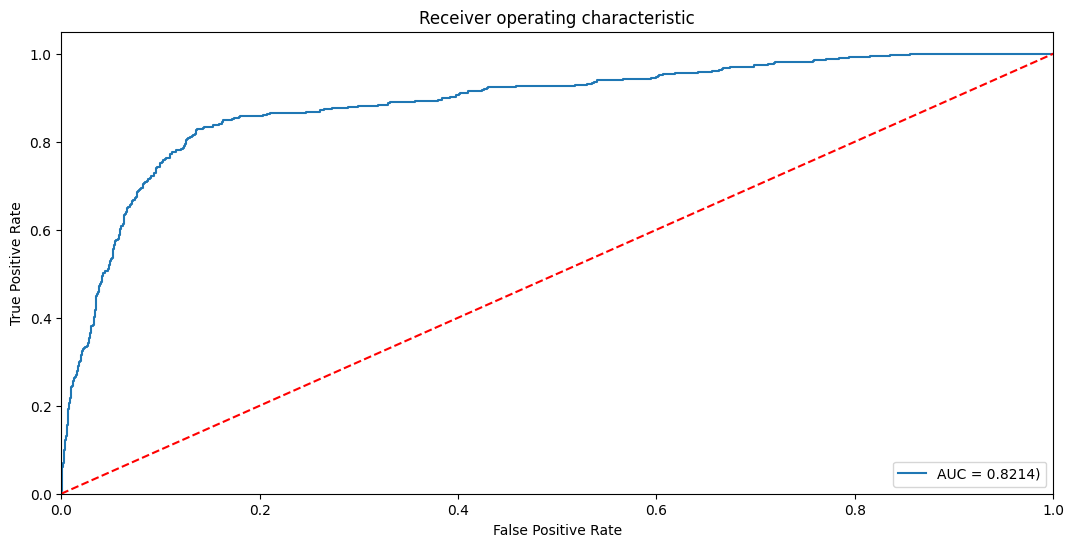

--------------------------------------------------
Best Parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [25]:
# Define the parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],   # Regularization type
    'solver': ['liblinear']    # Solver for l1/l2 penalties
}

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Grid Search
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42, class_weight=class_weights),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1
)

# Fit Grid Search
train_and_plot(grid_search_lr, X_train_smote, y_train_smote, X_test[selected_features_rfc], y_test)

# Best parameters
print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)

# Evaluate the best model
best_lr_model = grid_search_lr.best_estimator_

### Decision tree classifier

Model accuracy for train set: 0.947
Model accuracy for test set: 0.854

              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91      2055
         1.0       0.55      0.75      0.64       411

    accuracy                           0.86      2466
   macro avg       0.75      0.82      0.77      2466
weighted avg       0.88      0.86      0.86      2466


Confusion Matrix:
 [[1802  253]
 [ 101  310]]

Accuracy Score:  0.856


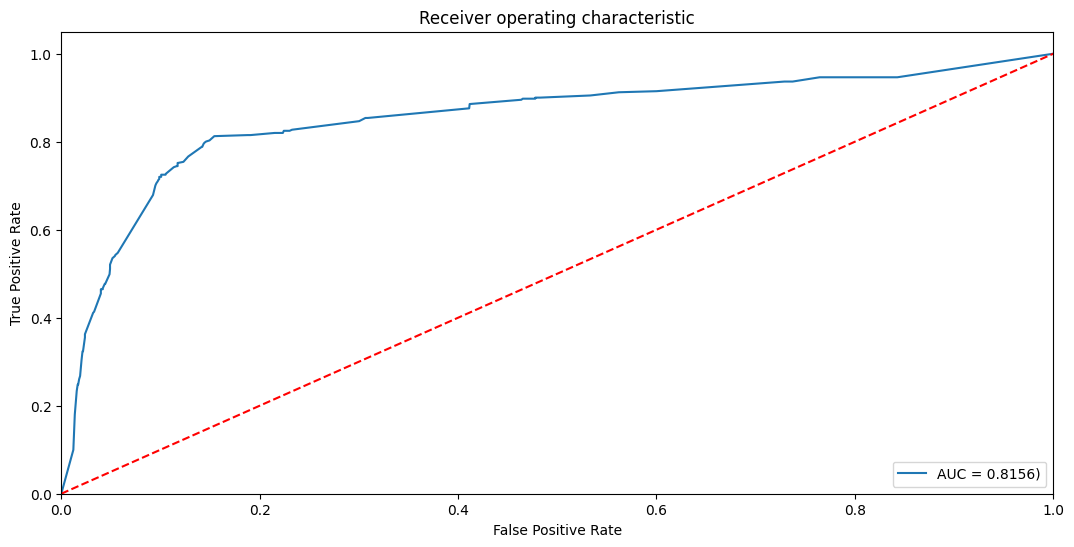

--------------------------------------------------
Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [26]:
# Define the parameter grid
param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Grid Search
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, class_weight=class_weights),
    param_grid=param_grid_dt,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1
)

# Fit Grid Search
train_and_plot(grid_search_dt, X_train_smote, y_train_smote, X_test[selected_features_rfc], y_test)

# Best parameters
print("Best Parameters for Decision Tree:", grid_search_dt.best_params_)

# Evaluate the best model
best_dt_model = grid_search_dt.best_estimator_

### Random forest classifier

Model accuracy for train set: 1.000
Model accuracy for test set: 0.884

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      2055
         1.0       0.56      0.74      0.64       411

    accuracy                           0.86      2466
   macro avg       0.75      0.81      0.77      2466
weighted avg       0.88      0.86      0.87      2466


Confusion Matrix:
 [[1817  238]
 [ 108  303]]

Accuracy Score:  0.86


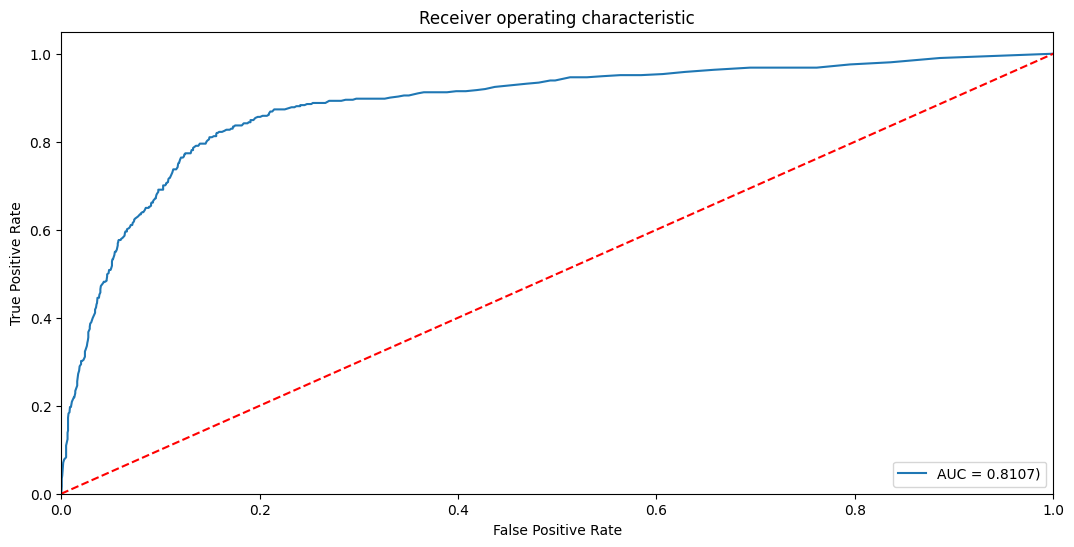

--------------------------------------------------
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


In [27]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize Grid Search
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight=class_weights),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1
)

# Fit Grid Search
train_and_plot(grid_search_rf, X_train_smote, y_train_smote, X_test[selected_features_rfc], y_test)

# Best parameters
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

# Evaluate the best model
best_rf_model = grid_search_rf.best_estimator_

### Extra trees classifier

Model accuracy for train set: 1.000
Model accuracy for test set: 0.878

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92      2055
         1.0       0.57      0.73      0.64       411

    accuracy                           0.86      2466
   macro avg       0.76      0.81      0.78      2466
weighted avg       0.88      0.86      0.87      2466


Confusion Matrix:
 [[1827  228]
 [ 111  300]]

Accuracy Score:  0.863


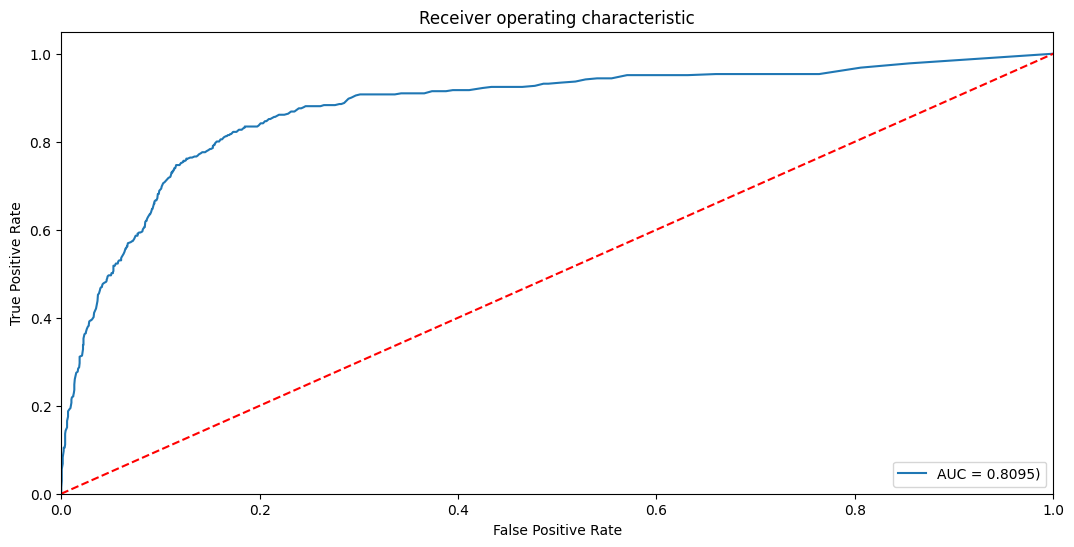

--------------------------------------------------
Best Parameters for Extra Trees: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


In [28]:
# Define the parameter grid
param_grid_et = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize Grid Search
grid_search_et = GridSearchCV(
    estimator=ExtraTreesClassifier(random_state=42, class_weight=class_weights),
    param_grid=param_grid_et,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1
)

# Fit Grid Search
train_and_plot(grid_search_et, X_train_smote, y_train_smote, X_test[selected_features_rfc], y_test)

# Best parameters
print("Best Parameters for Extra Trees:", grid_search_et.best_params_)

# Evaluate the best model
best_et_model = grid_search_et.best_estimator_

### Gradient boosting classifier

In [29]:
# Define the parameter grid
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize Grid Search
grid_search_gb = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1
)

# Fit Grid Search
train_and_plot(grid_search_gb, X_train_smote, y_train_smote, X_test[selected_features_rfc], y_test)

# Best parameters
print("Best Parameters for Gradient Boosting:", grid_search_gb.best_params_)

# Evaluate the best model
best_gb_model = grid_search_gb.best_estimator_

KeyboardInterrupt: 

### Histogram gradient boosting classifier


Model accuracy for train set: 0.988
Model accuracy for test set: 0.882

              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91      2055
         1.0       0.57      0.75      0.65       411

    accuracy                           0.86      2466
   macro avg       0.76      0.82      0.78      2466
weighted avg       0.88      0.86      0.87      2466


Confusion Matrix:
 [[1818  237]
 [ 101  310]]

Accuracy Score:  0.863


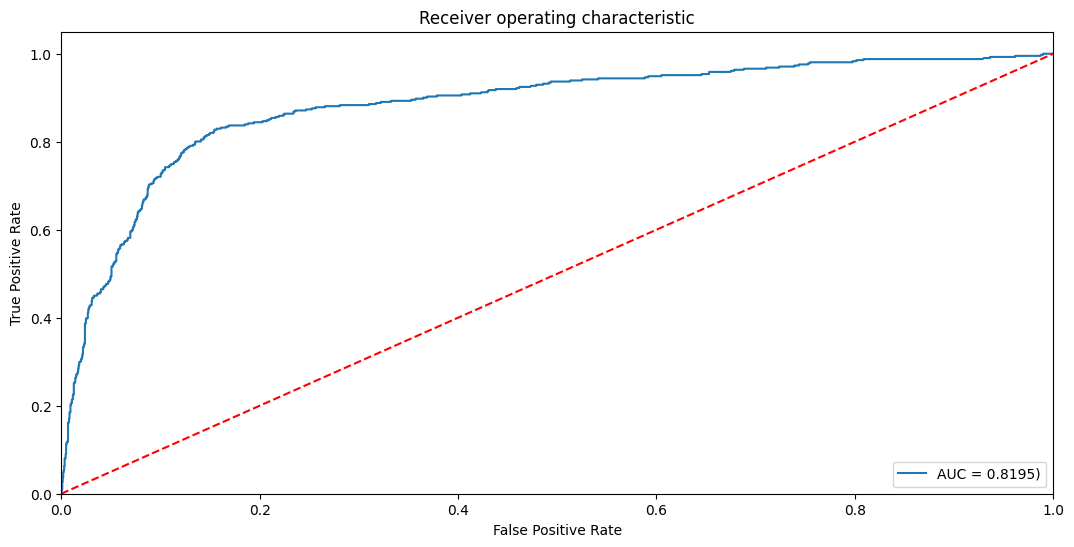

--------------------------------------------------
Best Parameters for Histogram Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 300}


In [35]:
# Define the parameter grid
param_grid_hgb = {
    'max_iter': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 10, 20]
}

# Initialize Grid Search
grid_search_hgb = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=42),
    param_grid=param_grid_hgb,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1
)

# Fit Grid Search
train_and_plot(grid_search_hgb, X_train_smote, y_train_smote, X_test[selected_features_rfc], y_test)

# Best parameters
print("Best Parameters for Histogram Gradient Boosting:", grid_search_hgb.best_params_)

# Evaluate the best model
best_hgb_model = grid_search_hgb.best_estimator_


### Support vector classifier

Model accuracy for train set: 0.914
Model accuracy for test set: 0.831

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92      2055
         1.0       0.58      0.73      0.65       411

    accuracy                           0.87      2466
   macro avg       0.76      0.81      0.78      2466
weighted avg       0.88      0.87      0.87      2466


Confusion Matrix:
 [[1837  218]
 [ 111  300]]

Accuracy Score:  0.867


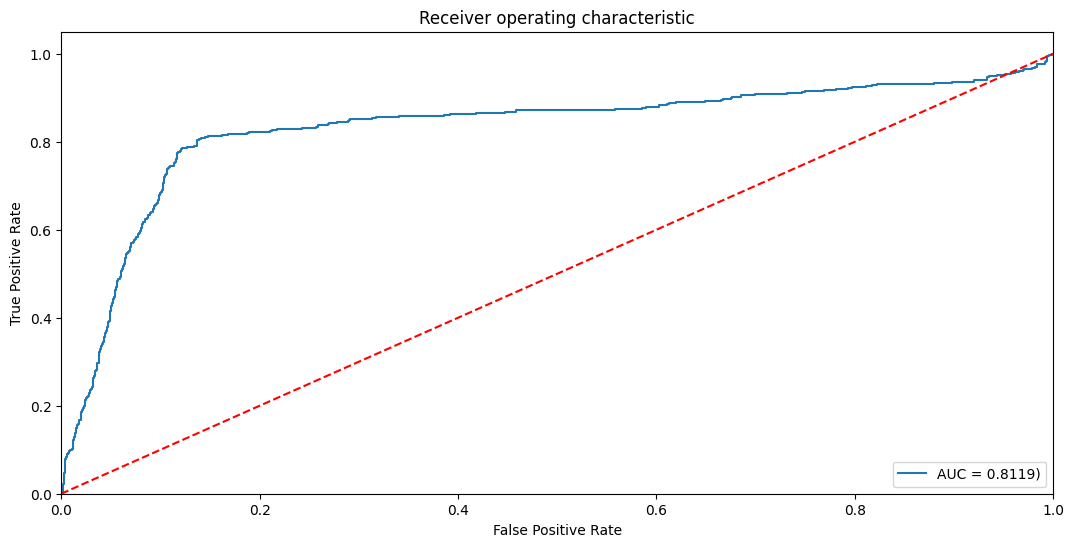

--------------------------------------------------
Best Parameters for SVC: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [36]:
# Define the parameter grid
param_grid_svc = {
    'C': [0.1, 1, 10],          # Regularization parameter
    'kernel': ['linear', 'rbf'], # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Initialize Grid Search
grid_search_svc = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid_svc,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1
)

# Fit Grid Search
train_and_plot(grid_search_svc, X_train_smote, y_train_smote, X_test[selected_features_rfc], y_test)

# Best parameters
print("Best Parameters for SVC:", grid_search_svc.best_params_)

# Evaluate the best model
best_svc_model = grid_search_svc.best_estimator_
